In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

2023-06-12 23:39:19.702986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:39:19.903657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-12 23:39:19.903703: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-12 23:39:21.156899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

In [2]:
expired_services = {
    "Single Sign-on": "Active Directory - ITS",
    "Password reset": "Active Directory - ITS",
    "Health IT Services ": "Other"
}

In [3]:
df = pd.read_csv("../data/validation_set.csv", index_col = 0)
X = df["desc"].fillna("None").to_numpy()
le = LabelEncoder()
le.classes_ = np.load("services.npy", allow_pickle=True)
num_classes = len(le.classes_)
df["service_offering"] = df["service_offering"].map(
    lambda x: expired_services[x] if x in expired_services.keys() else x,
    na_action="ignore"
)
y = df["service_offering"]

In [4]:
groups = df.groupby("service_offering")
val_subsets = {group[0]: group[1] for group in groups}

In [5]:
# val_subsets["Access to Business Applications"]["servi"]

In [6]:
le.classes_

array(['Access to Business Applications', 'Active Directory - ITS',
       'Campus Wired Networking', 'Campus Wireless Networking',
       'Canvas LMS', 'Domain Name Registration',
       'Enterprise Software Licensing Support', 'Exchange Online',
       'Hardware Endpoint Support', 'Health IT Services ',
       'IP Address Management (hostmaint, ethernet registration form) ',
       'MultiFactor Authentication', 'Non ITS Support', 'Office 365',
       'Online Directory', 'Other', 'Password reset',
       'Platform Operations & Management ', 'SSL / Digital Certificates',
       'Single Sign-on', 'Software Endpoint Support',
       'Spam / Duplicate Case', 'Virtual Private Network (VPN)',
       'Web & Video Conferencing (Zoom)', 'Web Content Management',
       'Wireless Residential Networking'], dtype=object)

<AxesSubplot:ylabel='service_offering'>

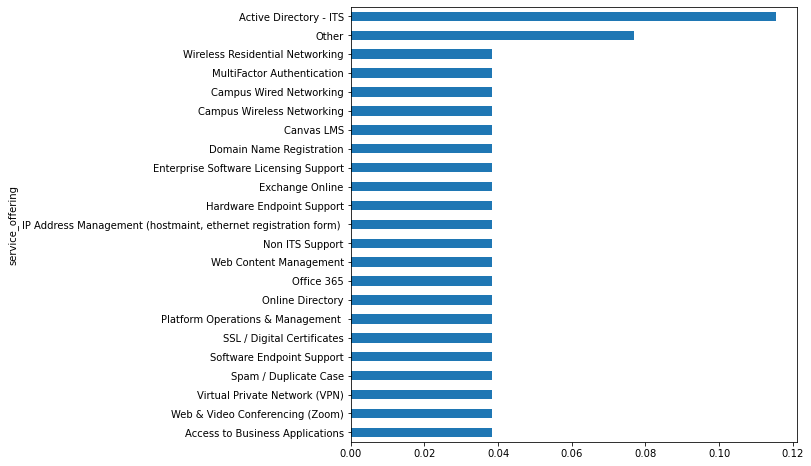

In [7]:
(df.groupby(df["service_offering"])["desc"].count() / df.shape[0]).sort_values().plot(kind="barh", figsize=(8,8))

In [8]:
def predict(mdl, desc, le, correction):
    probabilities = np.argmax(mdl.predict(x = desc), axis=1)
    labels = le.inverse_transform(probabilities)
    for idx, label in enumerate(labels):
        if label in correction.keys():
            labels[idx] = correction[label]
    return labels

In [9]:
new_model = tf.keras.models.load_model('saved_model/best_top_25_bert_small', compile=False)
new_model.summary()

2023-06-12 23:39:23.889654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-12 23:39:23.889834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-12 23:39:23.889952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-12 23:39:23.890065: W tensorflow/compiler/xla/stream_executor/platform/defa

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [10]:
y

0       IP Address Management (hostmaint, ethernet reg...
1                                         Non ITS Support
2                                  Active Directory - ITS
3                                         Non ITS Support
4                                                   Other
                              ...                        
4155                                                Other
4156                           MultiFactor Authentication
4157                            Software Endpoint Support
4158                            Hardware Endpoint Support
4159                                                Other
Name: service_offering, Length: 4160, dtype: object

In [11]:
predictions = predict(new_model, X, le, expired_services)

130/130 [==============================] - 48s 365ms/step


In [12]:
predictions.shape

(4160,)

In [13]:
val_acc = np.mean(predictions==y)
print(f"Validation accuracy on a balanced dataset yields an accuracy of {val_acc * 100 :.2f}%")

Validation accuracy on a balanced dataset yields an accuracy of 66.78%


In [14]:
services_acc = {}
for service in val_subsets:
    df = val_subsets[service]
    X, y = df["desc"], df["service_offering"]
    preds = predict(new_model, X, le, expired_services)
    acc = np.mean(preds == y)
    services_acc[service] = acc

5/5 [==============================] - 2s 349ms/step


In [15]:
services_acc

{'Access to Business Applications': 0.4875,
 'Active Directory - ITS': 0.70625,
 'Campus Wired Networking': 0.8125,
 'Campus Wireless Networking': 0.475,
 'Canvas LMS': 0.8125,
 'Domain Name Registration': 0.63125,
 'Enterprise Software Licensing Support': 0.88125,
 'Exchange Online': 0.5,
 'Hardware Endpoint Support': 0.68125,
 'IP Address Management (hostmaint, ethernet registration form) ': 0.4875,
 'MultiFactor Authentication': 0.8125,
 'Non ITS Support': 0.26875,
 'Office 365': 0.75625,
 'Online Directory': 1.0,
 'Other': 0.371875,
 'Platform Operations & Management ': 0.90625,
 'SSL / Digital Certificates': 0.76875,
 'Software Endpoint Support': 0.4125,
 'Spam / Duplicate Case': 0.625,
 'Virtual Private Network (VPN)': 0.73125,
 'Web & Video Conferencing (Zoom)': 0.86875,
 'Web Content Management': 0.875,
 'Wireless Residential Networking': 0.70625}

In [16]:
import seaborn as sns

In [17]:
services_acc

{'Access to Business Applications': 0.4875,
 'Active Directory - ITS': 0.70625,
 'Campus Wired Networking': 0.8125,
 'Campus Wireless Networking': 0.475,
 'Canvas LMS': 0.8125,
 'Domain Name Registration': 0.63125,
 'Enterprise Software Licensing Support': 0.88125,
 'Exchange Online': 0.5,
 'Hardware Endpoint Support': 0.68125,
 'IP Address Management (hostmaint, ethernet registration form) ': 0.4875,
 'MultiFactor Authentication': 0.8125,
 'Non ITS Support': 0.26875,
 'Office 365': 0.75625,
 'Online Directory': 1.0,
 'Other': 0.371875,
 'Platform Operations & Management ': 0.90625,
 'SSL / Digital Certificates': 0.76875,
 'Software Endpoint Support': 0.4125,
 'Spam / Duplicate Case': 0.625,
 'Virtual Private Network (VPN)': 0.73125,
 'Web & Video Conferencing (Zoom)': 0.86875,
 'Web Content Management': 0.875,
 'Wireless Residential Networking': 0.70625}

In [18]:
acc_df = pd.DataFrame(data=services_acc.values(), index = services_acc.keys(), columns=["acc"])
acc_df = acc_df.sort_values(by="acc")

In [19]:
import matplotlib.pyplot as plt

In [20]:
val_subsets["Online Directory"]

,desc,service_offering
38,received from: creyesgonzalez@ucsd.edu\n\nUpda...,Online Directory
50,received from: alubar@ucsd.edu\n\nUpdate Direc...,Online Directory
123,received from: ksilva@ucsd.edu\n\nUpdate Direc...,Online Directory
130,received from: mtristaoparra@ucsd.edu\n\nUpdat...,Online Directory
148,received from: decaruthers@ucsd.edu\n\nUpdate ...,Online Directory
...,...,...
4087,received from: nmazurkivich@ucsd.edu\n\nUpdate...,Online Directory
4104,received from: newcsr@ucsd.edu\n\n Your reques...,Online Directory
4112,received from: j6olson@UCSD.EDU\n\nUpdate Dire...,Online Directory
4130,received from: jlv001@ucsd.edu\n\nUpdate Direc...,Online Directory


In [21]:
for idx, x in enumerate(acc_df["acc"]):
    print(idx, x)

0 0.26875
1 0.371875
2 0.4125
3 0.475
4 0.4875
5 0.4875
6 0.5
7 0.625
8 0.63125
9 0.68125
10 0.70625
11 0.70625
12 0.73125
13 0.75625
14 0.76875
15 0.8125
16 0.8125
17 0.8125
18 0.86875
19 0.875
20 0.88125
21 0.90625
22 1.0


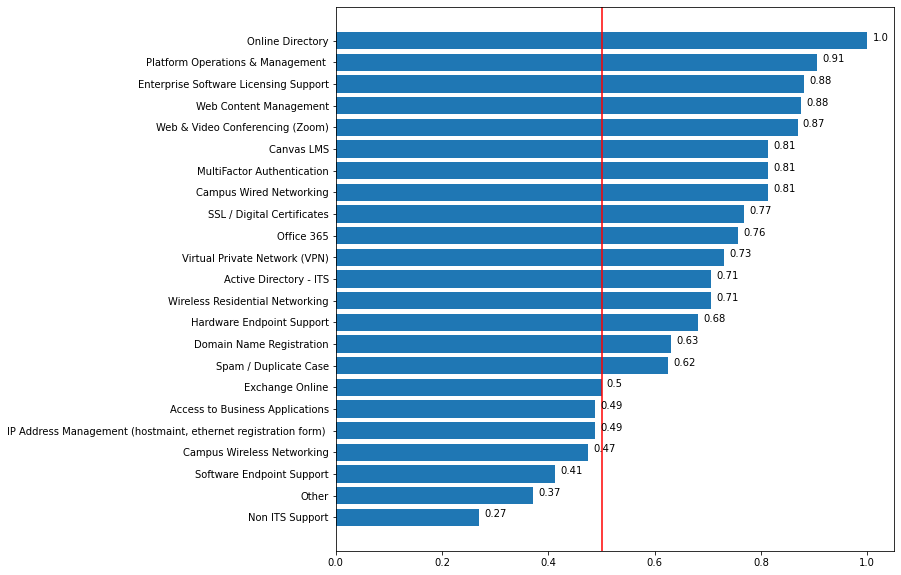

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
# acc_df.sort_values(by="acc").plot(kind="barh", figsize=(8,8))
ax.barh(acc_df.index, acc_df["acc"])
ax.axvline(x=0.5, color="red")
for i, v in enumerate(acc_df["acc"]):
    ax.text(v + 0.01, i, str(round(v, 2)), ha="left")
plt.show()

In [36]:
le.categories

LabelEncoder()

In [23]:
test = [
    """received from: efgrossm@eng.ucsd.edu Hi UCSD service desk,I am trying to access MyStudentChart, 
    but my phone broke yesterday. I cannot use DuoMobile to confirm login from my computer. 
    Can I get a bypass code while I wait for my new phone to come? -Esther
    """]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 77ms/step


array(['MultiFactor Authentication'], dtype=object)

In [24]:
test = [
    """received from: rsotelo@ucsd.edu

Hi Service desk,

Can you please help me register my era commons username RYSOTELO and USCD affiliation to DUO.

Thank you,

Raquel
"""]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 71ms/step


array(['MultiFactor Authentication'], dtype=object)

In [25]:
test = ["My account is compromised, I need to change my password"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 71ms/step


array(['Password reset'], dtype=object)

In [26]:
test = ["My Duo Mobile app is not working and I can't ask it to call me anymore."]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 63ms/step


array(['MultiFactor Authentication'], dtype=object)

In [27]:
test = ["Wifi at Sixth college is not working. All of my friends are reporting a problem"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 69ms/step


array(['Wireless Residential Networking'], dtype=object)

In [28]:
test = ["My VPN is not working. It is stuck on trying to connect when I type in my password"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 72ms/step


array(['Virtual Private Network (VPN)'], dtype=object)

In [29]:
test = ["I am not receiving any emails in my Outlook exchange. The last email I got was 2 months ago. HELP!!!"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 74ms/step


array(['Exchange Online'], dtype=object)

In [30]:
test = ["I need to register my Microsoft Exchange account. I can't receive any emails as of right now."]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 72ms/step


array(['Exchange Online'], dtype=object)

In [31]:
test = ["I just registered for Math 189 yesterday and it is not showing up as a course on my Canvas page. Please help"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 75ms/step


array(['Canvas LMS'], dtype=object)

In [32]:
test = ["My docking station is broken, the monitors connected to it does not work"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 73ms/step


array(['Hardware Endpoint Support'], dtype=object)

In [33]:
test = ["My laptop is not turning on and I have work today. Please help ASAP"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 74ms/step


array(['Hardware Endpoint Support'], dtype=object)

In [34]:
test = ["My health email is not receiving any emails, what is going on?"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 73ms/step


array(['Health IT Services '], dtype=object)

In [35]:
test = ["I need Adobe Acrobat for work, how can I get that on my account?"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 77ms/step


array(['Software Endpoint Support'], dtype=object)